In [2]:
#importing the libraries 
import timeshap 
from aeon.datasets import load_classification
import numpy as np
import matplotlib.pyplot as plt


import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
import numpy as np

from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from sklearn.metrics import accuracy_score

In [3]:
pip install sktime


Note: you may need to restart the kernel to use updated packages.


In [4]:
import warnings

from aeon.registry import all_estimators

warnings.filterwarnings("ignore")
all_estimators("classifier", filter_tags={"algorithm_type": "deeplearning"})

[('CNNClassifier', aeon.classification.deep_learning.cnn.CNNClassifier),
 ('EncoderClassifier',
  aeon.classification.deep_learning.encoder.EncoderClassifier),
 ('FCNClassifier', aeon.classification.deep_learning.fcn.FCNClassifier),
 ('InceptionTimeClassifier',
  aeon.classification.deep_learning.inception_time.InceptionTimeClassifier),
 ('IndividualInceptionClassifier',
  aeon.classification.deep_learning.inception_time.IndividualInceptionClassifier),
 ('MLPClassifier', aeon.classification.deep_learning.mlp.MLPClassifier),
 ('ResNetClassifier',
  aeon.classification.deep_learning.resnet.ResNetClassifier),
 ('TapNetClassifier',
  aeon.classification.deep_learning.tapnet.TapNetClassifier)]

In [5]:

# Load a dataset by name
dataset_name = 'FordA'  # replace with the actual name of the dataset you wish to load
data = load_classification(dataset_name)

In [7]:
data


(array([[[-0.79717168, -0.66439208, -0.37301463, ..., -0.66439208,
          -1.0737958 , -1.5643427 ]],
 
        [[ 0.80485472,  0.63462859,  0.37347448, ..., -0.71488505,
          -0.56044294, -0.31908642]],
 
        [[ 0.7279851 ,  0.11128392, -0.49912439, ...,  0.39446303,
           0.33940042,  0.25539062]],
 
        ...,
 
        [[ 0.71008362,  0.59397882,  0.3818858 , ..., -0.12655282,
          -0.11782239, -0.18909413]],
 
        [[ 0.00684706, -0.14062427, -0.27059412, ..., -1.0007084 ,
          -1.0841075 , -1.109963  ]],
 
        [[-0.54135529, -0.24172258,  0.10074086, ..., -0.09362504,
          -0.90080431, -1.778341  ]]]),
 array(['-1', '1', '-1', ..., '1', '1', '1'], dtype='<U2'),
 {'problemname': 'forda',
  'timestamps': False,
  'missing': False,
  'univariate': True,
  'equallength': True,
  'classlabel': True,
  'targetlabel': False,
  'class_values': ['-1', '1']})

In [8]:
data[0].shape

(4921, 1, 500)

In [9]:
# Load the data using the function
data, labels, metadata = load_classification('FordA')  # Replace 'forda' with your specific dataset if needed

# Print the shapes of the data and labels
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)

# Determine and print the number of unique classes
num_classes = len(np.unique(labels))
print("Number of classes:", num_classes)

# Optionally, print the metadata
print("Metadata:", metadata)


Data shape: (4921, 1, 500)
Labels shape: (4921,)
Number of classes: 2
Metadata: {'problemname': 'forda', 'timestamps': False, 'missing': False, 'univariate': True, 'equallength': True, 'classlabel': True, 'targetlabel': False, 'class_values': ['-1', '1']}


In [10]:
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)
num_classes = len(np.unique(labels))
print("Number of classes:", num_classes)


Data shape: (4921, 1, 500)
Labels shape: (4921,)
Number of classes: 2


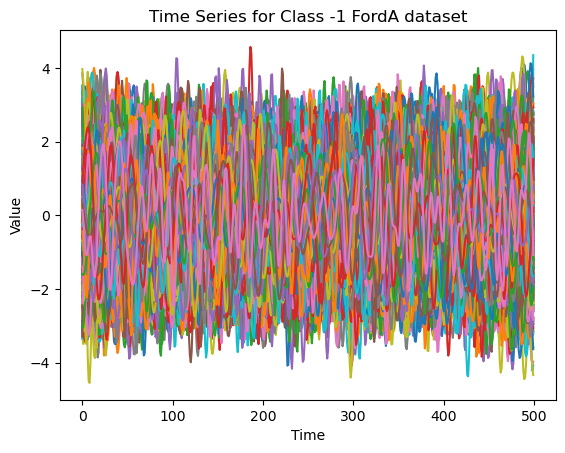

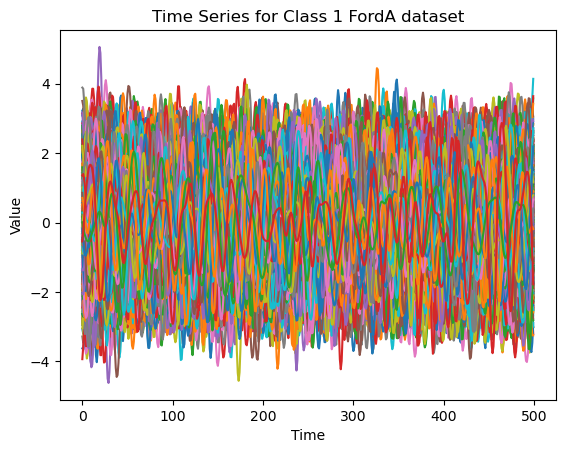

In [11]:

# Unpack the data
time_series_data, class_labels, metadata = load_classification('FordA')
# Convert class labels to integers
class_labels = class_labels.astype(int)


# Get the unique class labels
unique_labels = np.unique(class_labels)

# Plot each class separately
for label in unique_labels:
    class_indices = np.where(class_labels == label)[0]
    
    for idx in class_indices:
        plt.plot(time_series_data[idx, 0, :])  # Assuming 1D time series
        
    plt.title(f'Time Series for Class {label} FordA dataset')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.show()


In [12]:
# Define the sizes
train_size = 3601
test_size = 1320  # Make sure that train_size + test_size <= total number of samples

# Split the data
x_train = data[:train_size]
y_train = labels[:train_size]
x_test = data[train_size:train_size+test_size]
y_test = labels[train_size:train_size+test_size]


In [13]:
print("Training data shape:", x_train.shape)
print("Training labels shape:", y_train.shape)
print("Testing data shape:", x_test.shape)
print("Testing labels shape:", y_test.shape)


Training data shape: (3601, 1, 500)
Training labels shape: (3601,)
Testing data shape: (1320, 1, 500)
Testing labels shape: (1320,)


In [19]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.preprocessing import LabelEncoder


# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit the encoder to the training labels and transform the labels to integers
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)  # Transform the test labels using the same encoder

# Convert the encoded labels and data  to PyTorch tensors
y_train_tensor = torch.tensor(y_train_encoded).long()
y_test_tensor = torch.tensor(y_test_encoded).long()
X_train_tensor = torch.Tensor(x_train)
X_test_tensor = torch.Tensor(x_test)

In [20]:

# Create dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [21]:
import torch.nn as nn
import torch.nn.functional as F

class FCN(nn.Module):
    def __init__(self, num_classes):
        super(FCN, self).__init__()
        self.conv1 = nn.Conv1d(1, 128, kernel_size=8, padding=3)
        self.conv2 = nn.Conv1d(128, 256, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(256, 128, kernel_size=3, padding=1)
        self.global_pooling = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.global_pooling(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Create the model
num_classes = len(np.unique(y_train))  # Assuming y_train contains all possible classes
model = FCN(num_classes=num_classes)


In [22]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for data, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}, Loss: {loss.item()}')


Epoch 1, Loss: 0.5101909637451172
Epoch 2, Loss: 0.4357185959815979
Epoch 3, Loss: 0.4784940779209137
Epoch 4, Loss: 0.4928351640701294
Epoch 5, Loss: 0.3345995843410492
Epoch 6, Loss: 0.36643803119659424
Epoch 7, Loss: 0.5535634160041809
Epoch 8, Loss: 0.42460694909095764
Epoch 9, Loss: 0.09180131554603577
Epoch 10, Loss: 0.16628247499465942


In [23]:
correct = 0
total = 0
with torch.no_grad():
    for data, labels in test_loader:
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test data: {100 * correct / total}%')


Accuracy of the network on the test data: 88.78787878787878%


In [25]:
pip install optuna


  Obtaining dependency information for optuna from https://files.pythonhosted.org/packages/4c/6a/219a431aaf81b3eb3070fd2d58116baa366d3072f43bbcc87dc3495b7546/optuna-3.5.0-py3-none-any.whl.metadata
  Obtaining dependency information for alembic>=1.5.0 from https://files.pythonhosted.org/packages/7f/50/9fb3a5c80df6eb6516693270621676980acd6d5a9a7efdbfa273f8d616c7/alembic-1.13.1-py3-none-any.whl.metadata
  Obtaining dependency information for colorlog from https://files.pythonhosted.org/packages/95/df/520663eb7f7a329f7c585834b754bcc3cbcc03957d85fcbba4a2a723ad9d/colorlog-6.8.0-py3-none-any.whl.metadata
  Obtaining dependency information for Mako from https://files.pythonhosted.org/packages/24/3b/11fe92d68c6a42468ddab0cf03f454419b0788fff4e91ba46b8bebafeffd/Mako-1.3.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/413.4 kB ? eta -:--:--
    --------------------------------------- 10.2/413.4 kB ? eta -:--:--
    --------------------------------------- 10.2/413.4 kB ?

In [26]:
import optuna


def objective(trial):
    # Define hyperparameters to be tuned
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])

    # Create model, optimizer, criterion
    model = FCN(num_classes=num_classes)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Create DataLoader with the suggested batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for data, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation (or use a separate validation set if available)
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, labels in test_loader:
                outputs = model(data)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = correct / total

    # Optuna tries to minimize the returned value
    return -accuracy  # or return loss.item() if you want to minimize loss



In [27]:
study = optuna.create_study()
study.optimize(objective, n_trials=10)  # You can change the number of trials

print("Best hyperparameters: ", study.best_params)


[I 2024-01-03 19:31:37,004] A new study created in memory with name: no-name-59dc7b23-fa2d-4728-b1a9-7f666554e271
[I 2024-01-03 19:34:05,029] Trial 0 finished with value: -0.7712121212121212 and parameters: {'lr': 0.01944861841441638, 'optimizer': 'Adam', 'batch_size': 128}. Best is trial 0 with value: -0.7712121212121212.
[I 2024-01-03 19:36:33,128] Trial 1 finished with value: -0.5166666666666667 and parameters: {'lr': 0.07721468323160043, 'optimizer': 'SGD', 'batch_size': 64}. Best is trial 0 with value: -0.7712121212121212.
[I 2024-01-03 19:38:54,464] Trial 2 finished with value: -0.6893939393939394 and parameters: {'lr': 0.0016693844622043589, 'optimizer': 'RMSprop', 'batch_size': 64}. Best is trial 0 with value: -0.7712121212121212.
[I 2024-01-03 19:41:16,543] Trial 3 finished with value: -0.7909090909090909 and parameters: {'lr': 0.00017245808044780007, 'optimizer': 'Adam', 'batch_size': 64}. Best is trial 3 with value: -0.7909090909090909.
[I 2024-01-03 19:43:42,459] Trial 4 fi

Best hyperparameters:  {'lr': 0.0005896640442498653, 'optimizer': 'RMSprop', 'batch_size': 32}
